# **Face Recognition Project**


---


## Part 3. Face Recognition Pipeline

In [ ]:
import os
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="white")

import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device

device(type='cuda')

Перед началом работы необходимо установить необходимые зависимости, загрузить исходные данные, а также перенести необходимые классы для моделей из предыдущих частей

In [ ]:
! pip install pretrainedmodels

In [ ]:
import pretrainedmodels

In [ ]:
! pip3 install wldhx.yadisk-direct

In [ ]:
! yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw

https://downloader.disk.yandex.ru/disk/a9f6c43dce81d824851fe802c6524c9d5292f170424f2cadd24c2af471163cdb/668ef1fe/aZ8Akc9CqtcaAMvg9MkExUmNfU9U_vPugtmtwAC7LCh7Ob4GqD-JrqJl2rsy_hxC-1lho6HNKGxRJzyaqhvCBg%3D%3D?uid=0&filename=celebA_train_500.zip&disposition=attachment&hash=PKVHlR%2B3q03Ys8aOKp5s/dgbI1MoVhGrKn/oCUbHWox44FxZCGQEdyLSePCIwi7Tq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=170342993&hid=8e5296bb80b8febc2b500d8fd890bbcf&media_type=compressed&tknv=v2


In [ ]:
! wget "https://downloader.disk.yandex.ru/disk/a9f6c43dce81d824851fe802c6524c9d5292f170424f2cadd24c2af471163cdb/668ef1fe/aZ8Akc9CqtcaAMvg9MkExUmNfU9U_vPugtmtwAC7LCh7Ob4GqD-JrqJl2rsy_hxC-1lho6HNKGxRJzyaqhvCBg%3D%3D?uid=0&filename=celebA_train_500.zip&disposition=attachment&hash=PKVHlR%2B3q03Ys8aOKp5s/dgbI1MoVhGrKn/oCUbHWox44FxZCGQEdyLSePCIwi7Tq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=170342993&hid=8e5296bb80b8febc2b500d8fd890bbcf&media_type=compressed&tknv=v2" -O celebA.zip
! unzip celebA.zip

In [ ]:
def get_paths(dataset_type="train"):
    f = open("./celebA_train_500/celebA_train_split.txt", "r")
    image_labels = f.readlines()
    f.close()

    labels = {
        "train": 0,
        "val": 1,
        "test": 2,
    }

    image_labels = [item.strip().split() for item in image_labels]
    images = [item[0] for item in image_labels if int(item[1]) == labels[dataset_type]]

    image_paths = []
    for image in images:
        image_paths.append(os.path.join("./celebA_train_500/celebA_imgs/", image))

    return image_paths

In [ ]:
class celebADataset(Dataset):


    def __init__(
        self,
        dataset_type: str = "train",
        crop_images: bool = False,
        transform=None
    ):
        super().__init__()

        self.dataset_type = dataset_type
        self.crop_images = crop_images
        self.transform = transform
        self.image_paths = get_paths(self.dataset_type)

        f = open("./celebA_train_500/celebA_anno.txt", "r")
        image_labels = f.readlines()
        f.close()

        image_labels = [item.strip().split() for item in image_labels]
        image_labels = {image: int(label) for image, label in image_labels}

        self.image_labels = [int(image_labels[path.split("/")[-1]]) for path in self.image_paths]


    def __len__(self):
        return len(self.image_paths)


    def load_sample(self, file):
        image = Image.open(file)

        if self.crop_images:
            image = np.array(image)
            image = Image.fromarray(image[77:-41, 45:-50])

        return image


    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image_label = self.image_labels[index]

        image = self.load_sample(image_path)
        if self.transform:
            image = self.transform(image)

        return image, image_label

Класс для модели обученной на ArcFace Loss (подробнее см. часть 1)

In [ ]:
class ResNetArcFace(nn.Module):


    def __init__(self, pretrained, requires_grad):
        super(ResNetArcFace, self).__init__()

        if pretrained == True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)

        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False

        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(512 * 7 * 7, 512),
            nn.BatchNorm1d(512),
        )


    def forward(self, x):
        x = self.model.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

Класс для модели обученной для распознавания ключевых точек лица (подробнее см. 2 часть)

In [ ]:
class ResNetFaceLandmarks(nn.Module):


    def __init__(self, pretrained, requires_grad):
        super(ResNetFaceLandmarks, self).__init__()

        if pretrained == True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)

        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False

        self.l0 = nn.Linear(in_features=512, out_features=136)


    def forward(self, x):
        batch_size, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        l0 = self.l0(x)
        return l0

Класс для выравнивания лица (подробнее см. часть 2)

In [ ]:
class FaceAligner:


    def __init__(
        self,
        predictor: nn.Module,
        desired_left_eye = (0.32, 0.32),
        desired_face_width = 224,
        desired_face_height = 224
        ):
        self.predictor = predictor
        self.desired_left_eye = desired_left_eye
        self.desired_face_width = desired_face_width
        self.desired_face_height = desired_face_height


    def align(self, image):
        pred_landmarks = self.predictor(image.to(device))

        pred_landmarks = torch.squeeze(pred_landmarks.detach().cpu()).numpy()
        image = torch.squeeze(image.detach().cpu()).numpy()

        image = np.transpose(image, (1, 2, 0))
        pred_landmarks = pred_landmarks.reshape(-1, 2)

        # select the points of the left and right eyes
        left_eye_landmarks = pred_landmarks[36:42]
        right_eye_landmarks = pred_landmarks[42:48]

        # calculate the center of mass for each eye
        left_eye_center = left_eye_landmarks.mean(axis=0)
        right_eye_center = right_eye_landmarks.mean(axis=0)

        # calculate the coordinates of the central point between the eyes
        eyes_center = ((left_eye_center[0] + right_eye_center[0]) / 2, (left_eye_center[1] + right_eye_center[1]) / 2)

        # calculate the angle between the centers of the eyes
        dy = right_eye_center[1] - left_eye_center[1]
        dx = right_eye_center[0] - left_eye_center[1]
        angle = np.degrees(np.arctan2(dy, dx)) + 360

        # calculate the x-coordinate of the right eye
        # based on the desired x-coordinate of the left eye
        desired_right_eye_x = 1.0 - self.desired_left_eye[0]

        # calculating the scale of the new image
        dist = np.sqrt((dx ** 2) + (dy ** 2))
        desired_dist = (desired_right_eye_x - self.desired_left_eye[0]) * self.desired_face_width
        scale = desired_dist / dist

        M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

        tx = self.desired_face_width * 0.5
        ty = self.desired_face_height * self.desired_left_eye[1]
        M[0, 2] += (tx - eyes_center[0])
        M[1, 2] += (ty - eyes_center[1])

        (w, h) = (self.desired_face_width, self.desired_face_height)
        output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
        output = torch.FloatTensor(np.clip(output, 0, 1).transpose((2, 0, 1)))

        return output

### **Задача 5. (2 балла)**
 Собрать весь пайплайн распознавания лиц. Этому пайплайну должно быть можно подать на вход картинку с лицами, и пайплайн должен возвращать эмбеддинги всех найденных лиц. Хорошо будет продемонстрировать работу вашего пайплайна на паре лиц одинаковых и разных людей с подсчетом метрики расстояния между их эмбеддингами. В пайплайне можно использовать предобученную сеть для детекции лиц, или же обучить свою;

Мы подготовили картинки с лицами звезд

- *Устованим библиотеку моделей для распознавания лиц, и импортируем предобученную модель MTCNN*

In [ ]:
! pip install facenet-pytorch

In [ ]:
from facenet_pytorch import MTCNN

- *Загрузим сохраненные модели для классификации и поиска ключевых точек*

In [ ]:
# Load a model trained on Cross Entropy
resnet_ce = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")

resnet_ce.last_linear = nn.Linear(in_features=512, out_features=500)
resnet_ce.load_state_dict(torch.load("./drive/MyDrive/resnet_ce.pt", map_location=device))
resnet_ce.last_linear = nn.Identity()
resnet_ce = resnet_ce.to(device)

In [ ]:
# Load a model trained on ArcFace Locc
resnet_arcface = ResNetArcFace(pretrained=True, requires_grad=True)

resnet_arcface.load_state_dict(torch.load("./drive/MyDrive/resnet_arcface.pt", map_location=device))
resnet_arcface = resnet_arcface.to(device)

In [ ]:
# Load a model trained to search for key points
resnet_landmarks = ResNetFaceLandmarks(pretrained=True, requires_grad=True)
resnet_landmarks.load_state_dict(torch.load("./drive/MyDrive/resnet_landmarks.pt", map_location=device))
resnet_landmarks = resnet_landmarks.to(device)

In [ ]:
face_aligner = FaceAligner(predictor=resnet_landmarks)

In [ ]:
mtcnn = MTCNN(image_size=224, margin=50, min_face_size=40, keep_all=False, post_process=False, device=device)

Заново создадим датасеты, но теперь мы не будем обрезать изображения

In [ ]:
test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
batch_size = 32

celeba_val_dataset = celebADataset(dataset_type="val", crop_images=False, transform=test_val_transform)
celeba_test_dataset = celebADataset(dataset_type="test", crop_images=False, transform=test_val_transform)

celeba_val_dataloader = DataLoader(celeba_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
celeba_test_dataloader = DataLoader(celeba_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

- *Напишем класс для распознавания лиц (в него войдут все части пайплайна)*

In [ ]:
class FaceRecognition():

    def __init__(
        self,
        mtcnn: nn.Module,
        face_aligner_model: nn.Module,
        face_recognition_model: nn.Module,
    ):
        self.mtcnn = mtcnn
        self.face_aligner_model = face_aligner_model
        self.face_recognition_model = face_recognition_model


    def detect_faces(
        self,
        batch_images: torch.Tensor,
        batch_labels: torch.Tensor = None
    ):
        batch_faces = []
        face_labels = []

        for i, image in enumerate(batch_images):
            image = image.numpy().transpose((1, 2, 0)) * 255.

            self.mtcnn.eval()
            with torch.no_grad():
                face, prob = self.mtcnn(image, return_prob=True)

            if (prob is not None) and (prob > 0.9):
                face = np.clip(face / 255., 0, 1)
                batch_faces.append(face.detach().cpu())
                if batch_labels is not None:
                    face_labels.append(batch_labels[i])

        batch_faces = torch.stack(batch_faces)
        face_labels = torch.tensor(face_labels, dtype=int)

        return batch_faces, face_labels


    def get_aligned_faces(
        self,
        batch_faces: torch.Tensor,
      ):
        batch_aligned_faces = []

        for face in batch_faces:
            face = torch.unsqueeze(face, 0)

            self.face_aligner_model.predictor.eval()
            with torch.no_grad():
                aligned_face = self.face_aligner_model.align(face)

            batch_aligned_faces.append(aligned_face.detach().cpu())

        batch_aligned_faces = torch.stack(batch_aligned_faces)

        return batch_aligned_faces


    def get_embeddings(
        self,
        batch_images: torch.Tensor,
        batch_labels: torch.Tensor = None
    ):
        if batch_labels is not None:
            batch_faces, face_labels = self.detect_faces(batch_images, batch_labels)
        else:
            batch_faces, face_labels = self.detect_faces(batch_images)

        batch_aligned_faces = self.get_aligned_faces(batch_faces)
        self.face_recognition_model.eval()
        with torch.no_grad():
            batch_embeddings = self.face_recognition_model(batch_aligned_faces.to(device)).detach().cpu()

        if batch_labels is not None:
            return batch_embeddings, face_labels

        return batch_embeddings

In [ ]:
face_recognition_ce = FaceRecognition(mtcnn=mtcnn, face_aligner_model=face_aligner, face_recognition_model=resnet_ce)

In [ ]:
face_recognition_arcface = FaceRecognition(mtcnn=mtcnn, face_aligner_model=face_aligner, face_recognition_model=resnet_arcface)

- *Посморим результаты выравнивания изображений*

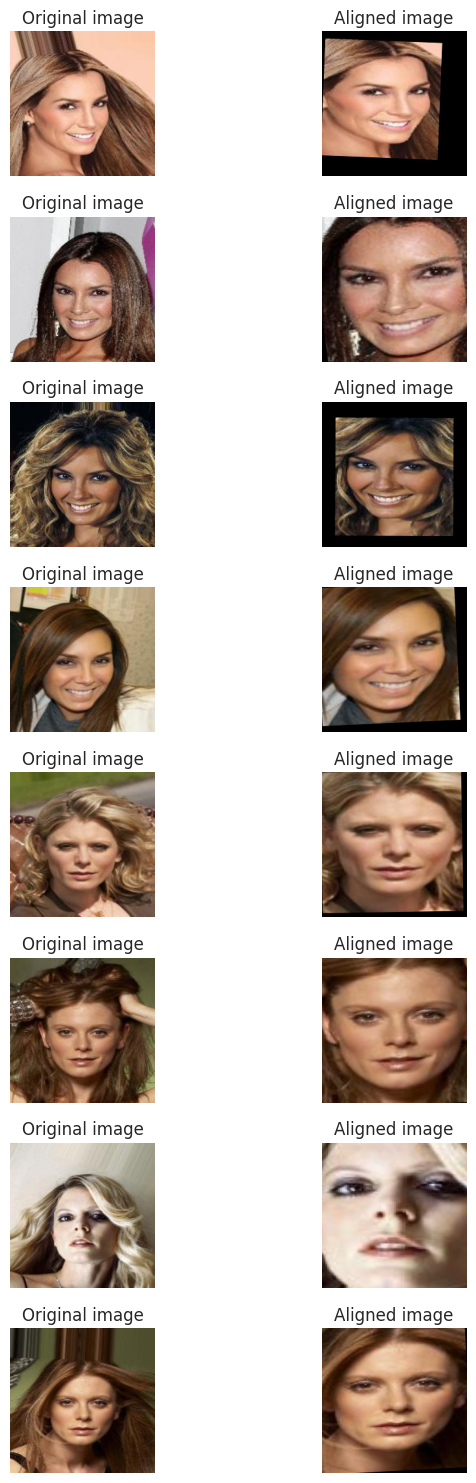

In [ ]:
images, labels = next(iter(celeba_test_dataloader))

nrows = 8; ncols=2
fig = plt.figure(figsize=(8, 15));

for i, image in enumerate(images):
    plt.subplot(nrows, ncols, i * ncols + 1)
    plt.imshow(image.permute((1, 2, 0)).numpy())
    plt.title("Original image")
    plt.axis("off")

    plt.subplot(nrows, ncols, i * ncols + 2)

    face, _ = face_recognition_ce.detect_faces(torch.unsqueeze(image, 0))
    aligned_face = face_recognition_ce.get_aligned_faces(face)
    plt.imshow(torch.squeeze(aligned_face).detach().cpu().numpy().transpose((1, 2, 0)))
    plt.title("Aligned image")
    plt.axis("off")

    if i == 7:
        plt.tight_layout()
        plt.show();
        break

Сравним две обученные модели для классификации

- *Вычислим евклидово и косинусное расстояния между эмбеддингами изображений и представим полученные матрицы расстояний в виде тепловой карты*

In [ ]:
from sklearn.metrics import pairwise_distances


def calculate_distance_metric(
    x: np.array,
    metric="euclidean",
    index=None,
    columns=None
):
    distances = pairwise_distances(x, x, metric=metric)
    return pd.DataFrame(distances, index=index, columns=columns)


def show_heatmap(
    ax,
    x: pd.DataFrame,
    title: str = "",
    annot: bool = False,
    fmt: str = ".2f"
):
    ax.set_title(title)
    sns.heatmap(x, square=True, annot=annot, ax=ax, fmt=fmt, linewidth=.5, cbar_kws={"shrink": 0.5})

In [ ]:
images, labels = next(iter(celeba_test_dataloader))

embeddings_ce, labels_ce = face_recognition_ce.get_embeddings(images, labels)
embeddings_ce = embeddings_ce.detach().cpu().numpy()
labels_ce = labels_ce.detach().cpu().numpy()

embeddings_arcface, labels_arcface = face_recognition_arcface.get_embeddings(images, labels)
embeddings_arcface = embeddings_arcface.detach().cpu().numpy()
labels_arcface = labels_arcface.detach().cpu().numpy()

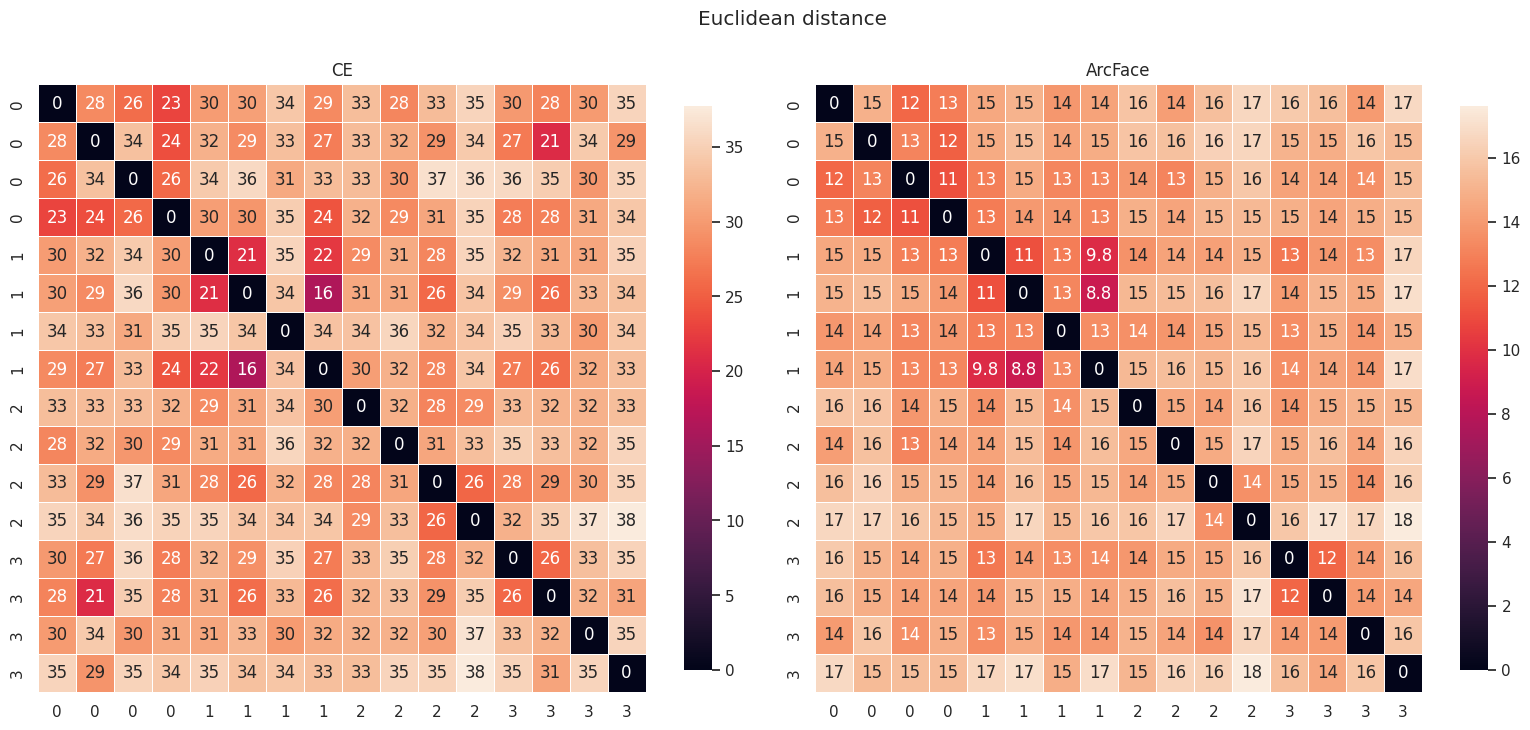

In [ ]:
euclidean_dist_ce = calculate_distance_metric(x=embeddings_ce[:16], metric="euclidean", index=labels_ce[:16], columns=labels_ce[:16])
euclidean_dist_arcface = calculate_distance_metric(x=embeddings_arcface[:16], metric="euclidean", index=labels_arcface[:16], columns=labels_arcface[:16])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 12))

show_heatmap(ax=ax[0], x=euclidean_dist_ce, title="CE", annot=True, fmt=".2g")
show_heatmap(ax=ax[1], x=euclidean_dist_arcface, title="ArcFace", annot=True, fmt=".2g")
plt.suptitle("Euclidean distance", y=0.8)
plt.tight_layout()
plt.show()

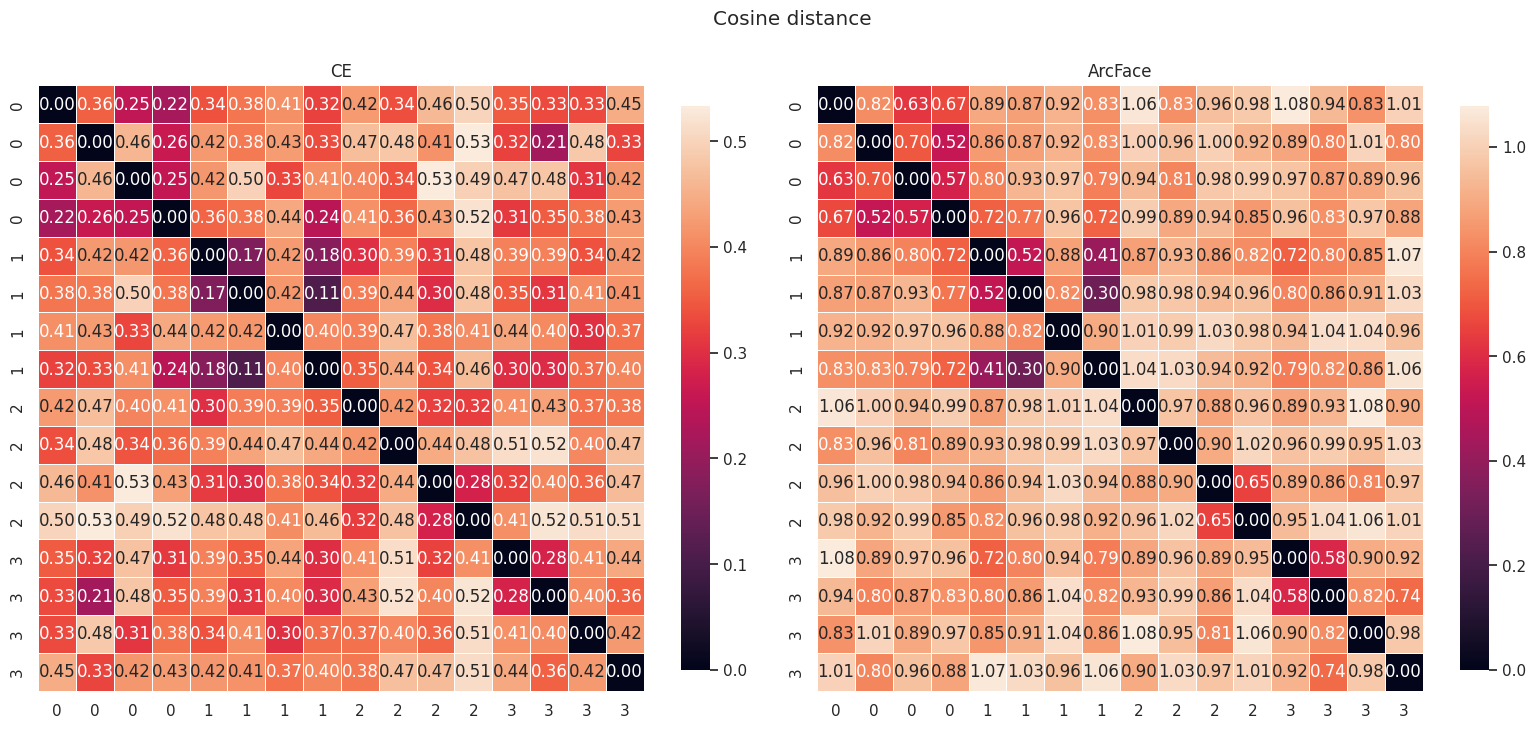

In [ ]:
cosine_dist_ce = calculate_distance_metric(x=embeddings_ce[:16], metric="cosine", index=labels_ce[:16], columns=labels_ce[:16])
cosine_dist_arcface = calculate_distance_metric(x=embeddings_arcface[:16], metric="cosine", index=labels_arcface[:16], columns=labels_arcface[:16])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 12))

show_heatmap(ax=ax[0], x=cosine_dist_ce, title="CE", annot=True, fmt=".2f")
show_heatmap(ax=ax[1], x=cosine_dist_arcface, title="ArcFace", annot=True, fmt=".2f")
plt.suptitle("Cosine distance", y=0.8)
plt.tight_layout()
plt.show()

- *Предствамим высокоразмерные эмбенддинги изображений в двумерном пространстве, используя алгоритм сжатия размерности TSNE*

In [ ]:
def show_tsne(
    ax,
    x: np.array,
    labels: np.array,
    title: str
):
    unique_labels = np.unique(labels)

    scatter_plot = ax.scatter(x=x[:, 0], y=x[:, 1], c=labels, cmap=plt.cm.get_cmap("tab20"))
    ax.set_title(title)

    cbar = plt.colorbar(scatter_plot, ax=ax)
    cbar.set_ticks(unique_labels)

In [ ]:
def get_images(
    dataloader: DataLoader,
    stop_index: int = 20
):
    batch_images = []
    batch_labels = []

    for images, labels in dataloader:
        for i, label in enumerate(labels):
            if label <= stop_index:
                batch_images.append(images[i])
                batch_labels.append(label)

    batch_images = torch.stack(batch_images)
    batch_labels = torch.stack(batch_labels)

    return batch_images, batch_labels

In [ ]:
val_images, val_labels = get_images(celeba_val_dataloader)
test_images, test_labels = get_images(celeba_test_dataloader)

images = torch.cat([val_images, test_images])
labels = torch.cat([val_labels, test_labels])

In [ ]:
embeddings_ce, labels_ce = face_recognition_ce.get_embeddings(images, labels)
embeddings_ce = embeddings_ce.detach().cpu().numpy()
labels_ce = labels_ce.detach().cpu().numpy()

embeddings_arcface, labels_arcface = face_recognition_arcface.get_embeddings(images, labels)
embeddings_arcface = embeddings_arcface.detach().cpu().numpy()
labels_arcface = labels_arcface.detach().cpu().numpy()

In [ ]:
from sklearn.manifold import TSNE

x_ce = TSNE(n_components=2, init="pca", metric="cosine", random_state=44).fit_transform(embeddings_ce)
x_arcface = TSNE(n_components=2, init="pca", metric="cosine", random_state=44).fit_transform(embeddings_arcface)

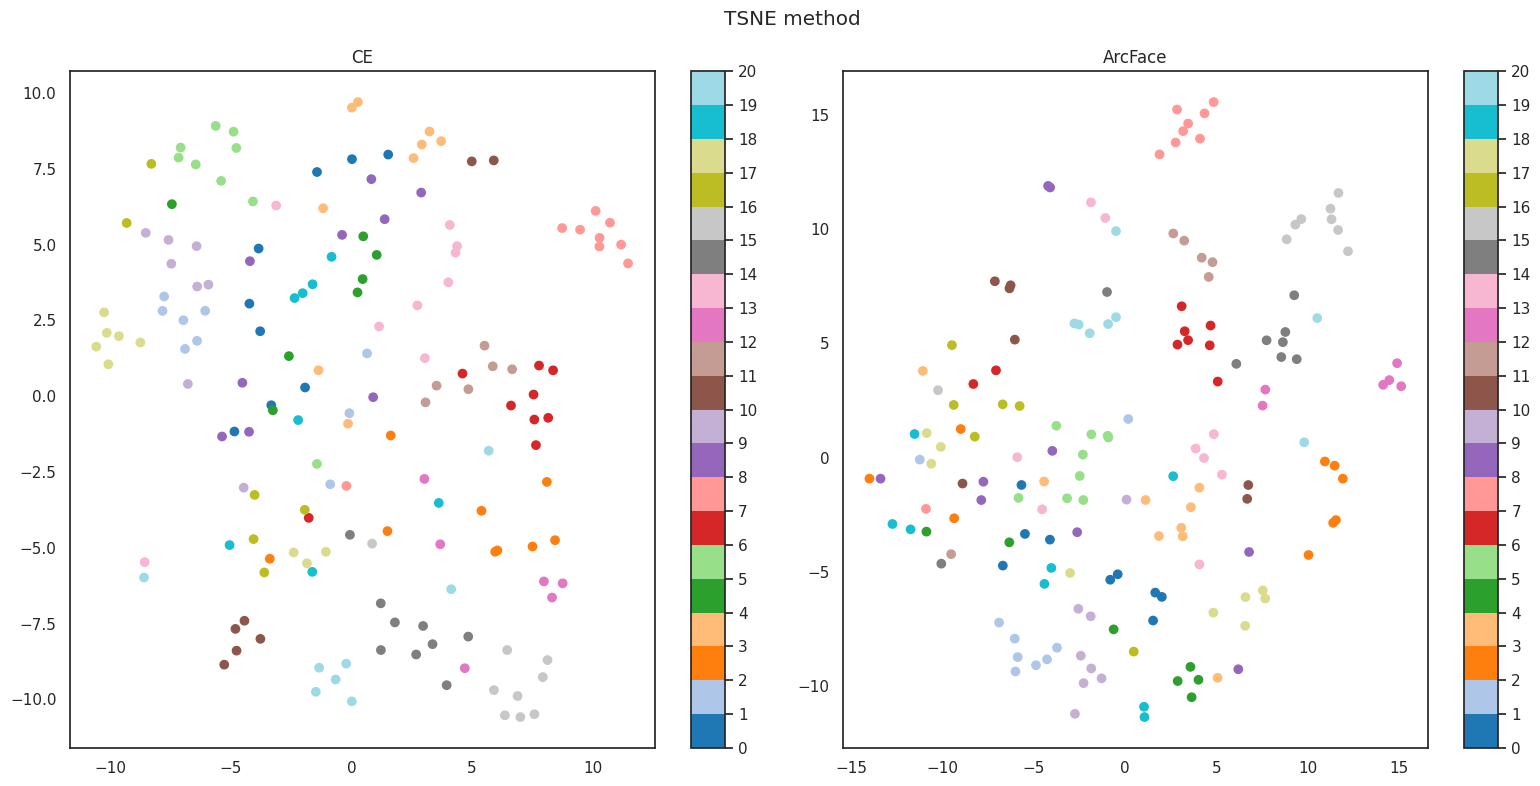

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

show_tsne(ax=ax[0], x=x_ce, labels=labels_ce, title="CE")
show_tsne(ax=ax[1], x=x_arcface, labels=labels_arcface, title="ArcFace")
plt.suptitle("TSNE method")
plt.tight_layout()
plt.show()

In [ ]:
def show_difference_between_images(
    image_1: torch.Tensor,
    image_2: torch.Tensor,
    titles: list[str],
    face_recognition_model
):
    """
        Show images with cosine distance between embeddings
    """
    embbeding_1 = face_recognition_model.get_embeddings(torch.unsqueeze(image_1, 0))
    embbeding_1 = torch.squeeze(embbeding_1).detach().cpu().numpy()
    embbeding_2 = face_recognition_model.get_embeddings(torch.unsqueeze(image_2, 0))
    embbeding_2 = torch.squeeze(embbeding_2).detach().cpu().numpy()
    cosine_distance = np.dot(embbeding_1, embbeding_2) / (np.linalg.norm(embbeding_1) * np.linalg.norm(embbeding_2))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

    ax[0].imshow(image_1.detach().cpu().numpy().transpose((1, 2, 0)))
    ax[0].set_title(f"Class label: {titles[0]}")
    ax[0].axis("off")

    ax[1].imshow(image_2.detach().cpu().numpy().transpose((1, 2, 0)))
    ax[1].set_title(f"Class label: {titles[1]}")
    ax[1].axis("off")

    plt.suptitle(f"Cosine distance = {cosine_distance:.4f}")
    plt.tight_layout()


- *Продемонстрируем работу работу пайплайна (где модель для классификации обучалась на **перекрестной энтропии**) на паре лиц одинаковых и разных людей с подсчетом метрики расстояния между их эмбеддингами*

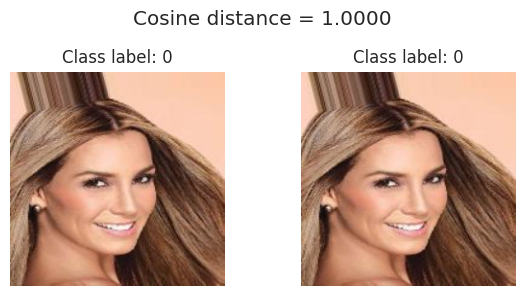

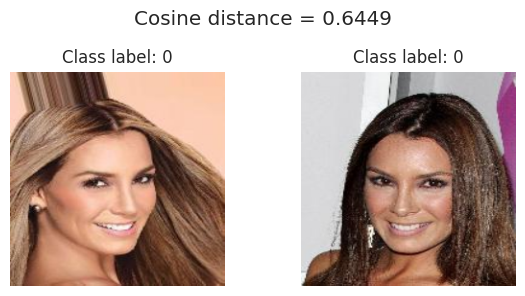

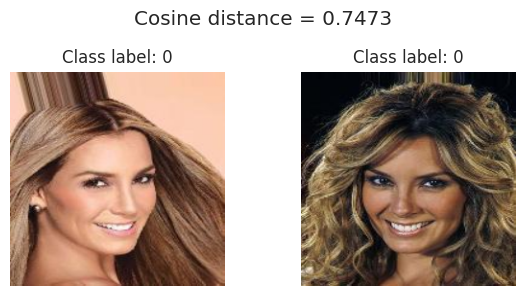

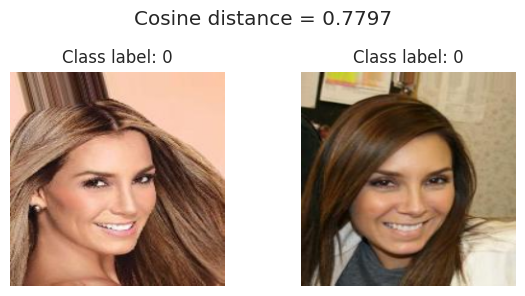

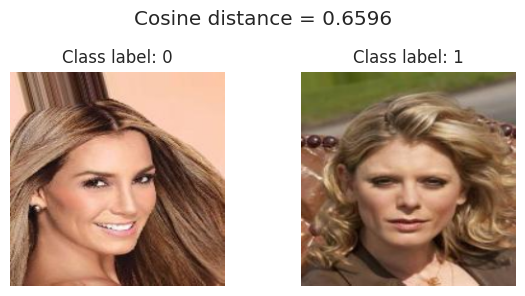

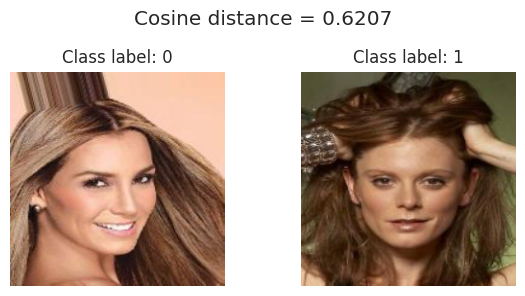

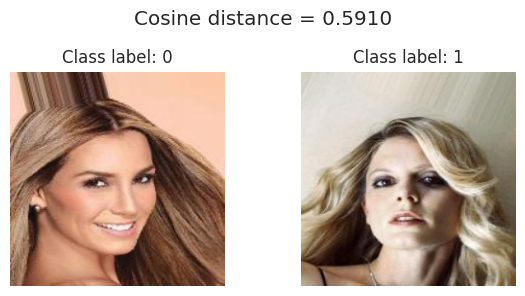

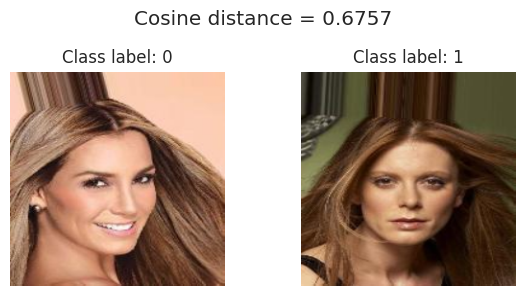

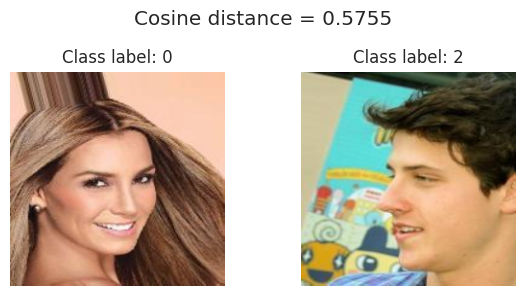

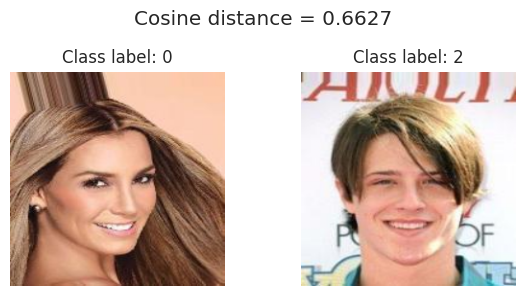

In [ ]:
images, labels = next(iter(celeba_test_dataloader))
target_index = 0

for i, image in enumerate(images):
    show_difference_between_images(image_1=images[target_index], image_2=image, face_recognition_model=face_recognition_ce, titles=[str(target_index), str(labels[i].item())])
    if i == 9:
        break

plt.show()

- *Продемонстрируем работу работу пайплайна (где модель для классификации обучалась c помощью **ArcFace Loss**) на паре лиц одинаковых и разных людей с подсчетом метрики расстояния между их эмбеддингами*

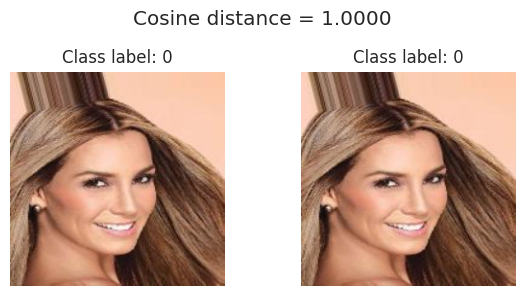

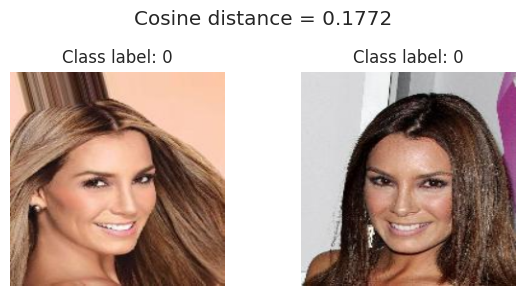

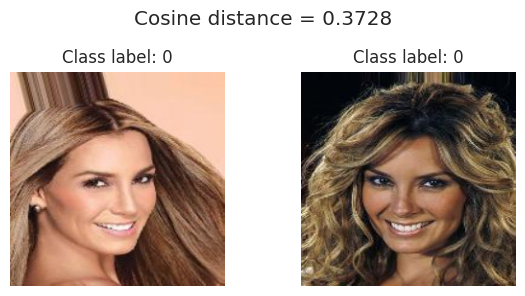

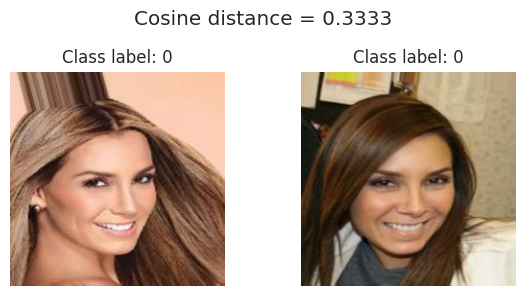

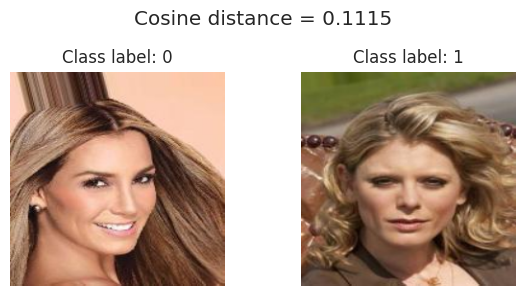

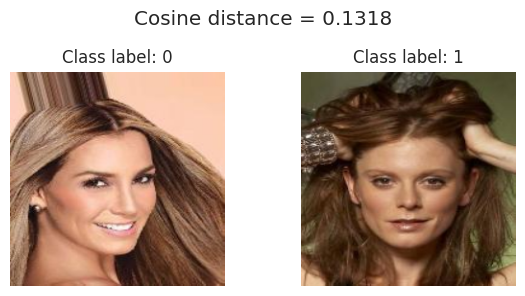

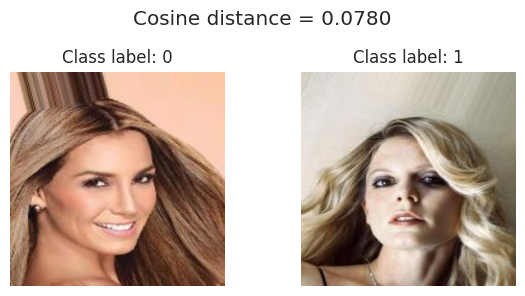

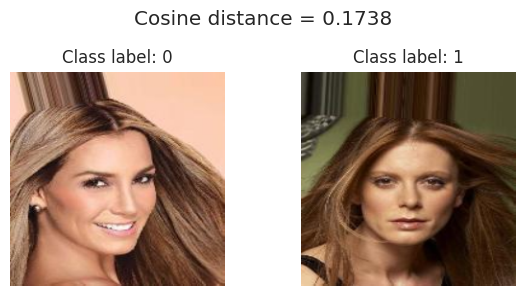

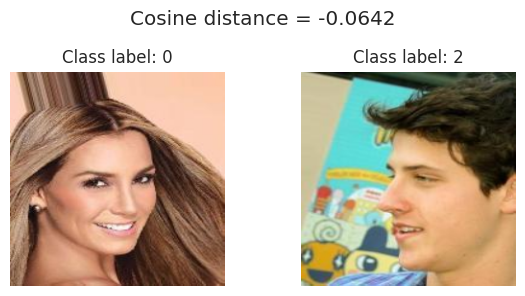

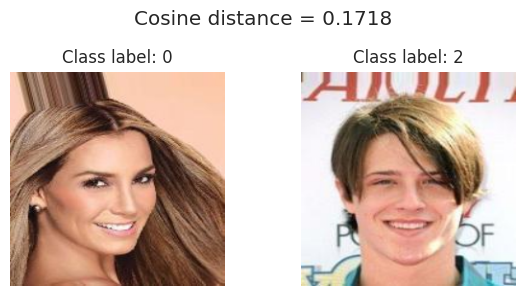

In [ ]:
for i, image in enumerate(images):
    show_difference_between_images(image_1=images[target_index], image_2=image, face_recognition_model=face_recognition_arcface, titles=[str(target_index), str(labels[i].item())])
    if i == 9:
        break

plt.show()